In [1]:
import torch
torch.manual_seed(42)
import torch.nn as nn
import torchvision.models as models
from libauc.optimizers import SGD, Adam,PESG
from libauc.losses import CrossEntropyLoss, AUCMLoss
from torch.utils.data import DataLoader, random_split
import os
os.environ['medmnist_data_dir'] = 'D:\\Download\\CSCE633\\project\\data'
import medmnist
from medmnist.dataset import AdrenalMNIST3D
# BreastMNIST, PneumoniaMNIST, ChestMNIST, NoduleMNIST3D, AdrenalMNIST3D, VesselMNIST3D, SynapseMNIST3D
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score
from medmnist import INFO, Evaluator
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchio as tio
import warnings
warnings.filterwarnings('ignore')

d:\adahx\anaconda3\envs\new_env_project\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


parameters

In [2]:
data_flag = 'adrenalmnist3d'

NUM_EPOCHS = 50
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [3]:
print("Task on this dataset is", task)
print("Number of channels", n_channels)
print("Number of classes", n_classes)

Task on this dataset is binary-class
Number of channels 1
Number of classes 2


preprosessing

In [4]:
# data augmentation
data_transform = tio.Compose([
    tio.Resample((1, 1, 1)),
    tio.CropOrPad((28, 28, 28)),
    tio.ToCanonical(),
    # add more transforms here
    tio.RandomAffine(scales=(0.9, 1.1), degrees=(-10, 10), translation=(-0.1, 0.1), center='image', isotropic=True, default_pad_value='mean', p=0.5),
    tio.RandomElasticDeformation(max_displacement=(5, 5, 5), num_control_points=(5, 5, 5), locked_borders=1, p=0.5),
    tio.RandomFlip(axes=(0, 1, 2), p=0.5),
    tio.RandomNoise(std=(0.01, 0.05), p=0.5),
])

In [5]:
data_dir = 'D:\\Download\\CSCE633\\project\\data'

In [6]:
# load data
train_data = DataClass(root=data_dir, split = 'train', transform=data_transform)
test_data = DataClass(root=data_dir, split = 'test', transform=data_transform)
val_data = DataClass(root=data_dir, split = 'val', transform=data_transform)


In [8]:
# add class weights for imbalanced dataset
binary_labels = [train_data[i][1] for i in range(len(train_data))]

# Count the number of positive (1) and negative (0) samples
positive_count = np.sum(binary_labels)
negative_count = len(binary_labels) - positive_count

print(f"Positive samples: {positive_count}")
print(f"Negative samples: {negative_count}")

Positive samples: 259
Negative samples: 929


In [7]:
positive_samples = 259
negative_samples = 929
total_samples = positive_samples + negative_samples

# Calculate class weights
class_weights = [total_samples / negative_samples, total_samples / positive_samples]

# Convert class weights to a tensor
class_weights_tensor = torch.FloatTensor(class_weights)

print(class_weights_tensor)

tensor([1.2788, 4.5869])


In [8]:
# dataloader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_data, batch_size=2*BATCH_SIZE, shuffle=False)

In [9]:
print(train_data)
print('=====================')
print(test_data)

Dataset AdrenalMNIST3D (adrenalmnist3d)
    Number of datapoints: 1188
    Root location: D:\Download\CSCE633\project\data
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'hyperplasia'}
    Number of samples: {'train': 1188, 'val': 98, 'test': 298}
    Description: The AdrenalMNIST3D is a new 3D shape classification dataset, consisting of shape masks from 1,584 left and right adrenal glands (i.e., 792 patients). Collected from Zhongshan Hospital Affiliated to Fudan University, each 3D shape of adrenal gland is annotated by an expert endocrinologist using abdominal computed tomography (CT), together with a binary classification label of normal adrenal gland or adrenal mass. Considering patient privacy, we do not provide the source CT scans, but the real 3D shapes of adrenal glands and their classification labels. We calculate the center of adrenal and resize the center-cropped 64mm×64mm×64mm volume into 28×28×28. The dataset 

In [10]:
res = [0]*11
for i in range(len(train_data.labels)):
    res[train_data.labels[i][0]] += 1
print(res)
img1 = train_data.montage(length = 10)
img1[10].show()

[929, 259, 0, 0, 0, 0, 0, 0, 0, 0, 0]


evaluation

In [10]:
def evaluate(dataloader):
    model.eval()
    correct = 0
    total = 0
    auc_score = 0.0
    skipped_batches = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.float().to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # Calculate AUC score (assuming binary classification)
            targets = targets.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()[:, 1]  # Get scores for the positive class
            
            # Check if there is more than one class in targets
            if len(np.unique(targets)) > 1:
                auc_score += roc_auc_score(targets, outputs)
            else:
                skipped_batches += 1

    acc = correct / total
    auc_score /= (len(dataloader) - skipped_batches)

    return auc_score, acc


# DAM

## Resnet18-3D

In [11]:
# from libauc.models import resnet18 as ResNet18
from resnet2p1d import generate_model
model_depth = 18

# Create the ResNet2p1D-18 model
model = generate_model(model_depth, n_input_channels=n_channels, n_classes=n_classes)


In [12]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [13]:
class_weights_tensor = class_weights_tensor.to(device)

In [14]:
# criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

Training with Adam optimizer...


100%|██████████| 38/38 [00:24<00:00,  1.54it/s]


==> Evaluating after epoch 1 ...
Train AUC: 0.61105302456177, Train ACC: 24.976430976430976
Test AUC: 0.5445917855292856, Test ACC: 24.14765100671141
==> Best test AUC and ACC score updated: 0.5446, 24.1477


100%|██████████| 38/38 [00:18<00:00,  2.05it/s]


==> Evaluating after epoch 2 ...
Train AUC: 0.7843746382128176, Train ACC: 24.26936026936027
Test AUC: 0.8303823468198468, Test ACC: 23.268456375838927
==> Best test AUC and ACC score updated: 0.8304, 23.2685


100%|██████████| 38/38 [00:15<00:00,  2.38it/s]


==> Evaluating after epoch 3 ...
Train AUC: 0.7622183325947726, Train ACC: 21.175084175084177
Test AUC: 0.8180423997298998, Test ACC: 21.073825503355703


100%|██████████| 38/38 [00:16<00:00,  2.31it/s]


==> Evaluating after epoch 4 ...
Train AUC: 0.7935262707149296, Train ACC: 22.496632996632997
Test AUC: 0.8472326862951863, Test ACC: 21.456375838926174
==> Best test AUC and ACC score updated: 0.8472, 21.4564


100%|██████████| 38/38 [00:16<00:00,  2.31it/s]


==> Evaluating after epoch 5 ...
Train AUC: 0.7642324985868838, Train ACC: 10.777777777777779
Test AUC: 0.7758555194805196, Test ACC: 11.080536912751677


100%|██████████| 38/38 [00:16<00:00,  2.31it/s]


==> Evaluating after epoch 6 ...
Train AUC: 0.7490533865165215, Train ACC: 20.95117845117845
Test AUC: 0.8182550019425019, Test ACC: 19.57046979865772


100%|██████████| 38/38 [00:16<00:00,  2.28it/s]


==> Evaluating after epoch 7 ...
Train AUC: 0.7808545226749026, Train ACC: 24.247474747474747
Test AUC: 0.7738680879305879, Test ACC: 23.604026845637584


100%|██████████| 38/38 [00:16<00:00,  2.31it/s]


==> Evaluating after epoch 8 ...
Train AUC: 0.809731902910646, Train ACC: 13.737373737373737
Test AUC: 0.7875066993191993, Test ACC: 13.879194630872483


100%|██████████| 38/38 [00:16<00:00,  2.32it/s]


==> Evaluating after epoch 9 ...
Train AUC: 0.8081623660420858, Train ACC: 17.72053872053872
Test AUC: 0.8213472476597478, Test ACC: 16.959731543624162


100%|██████████| 38/38 [00:16<00:00,  2.32it/s]


==> Evaluating after epoch 10 ...
Train AUC: 0.8231134042251183, Train ACC: 21.885521885521886
Test AUC: 0.821380075942576, Test ACC: 20.80536912751678


100%|██████████| 38/38 [00:16<00:00,  2.31it/s]


==> Evaluating after epoch 11 ...
Train AUC: 0.7540036061053678, Train ACC: 15.41077441077441
Test AUC: 0.7936850071225071, Test ACC: 15.060402684563758


100%|██████████| 38/38 [00:16<00:00,  2.31it/s]


==> Evaluating after epoch 12 ...
Train AUC: 0.8139618190583331, Train ACC: 11.644781144781145
Test AUC: 0.808341440966441, Test ACC: 11.651006711409396


100%|██████████| 38/38 [00:16<00:00,  2.32it/s]


==> Evaluating after epoch 13 ...
Train AUC: 0.8361307662853765, Train ACC: 18.47979797979798
Test AUC: 0.8786661417286418, Test ACC: 17.731543624161073
==> Best test AUC and ACC score updated: 0.8787, 17.7315


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]


==> Evaluating after epoch 14 ...
Train AUC: 0.8394421920830967, Train ACC: 18.006734006734007
Test AUC: 0.8331918521293522, Test ACC: 17.046979865771814


100%|██████████| 38/38 [00:16<00:00,  2.29it/s]


==> Evaluating after epoch 15 ...
Train AUC: 0.8345513969155274, Train ACC: 14.570707070707071
Test AUC: 0.8394663785288785, Test ACC: 14.912751677852349


100%|██████████| 38/38 [00:16<00:00,  2.29it/s]


==> Evaluating after epoch 16 ...
Train AUC: 0.8485474516445003, Train ACC: 18.95959595959596
Test AUC: 0.8465255346505346, Test ACC: 18.268456375838927


100%|██████████| 38/38 [00:17<00:00,  2.13it/s]


==> Evaluating after epoch 17 ...
Train AUC: 0.8264786864560482, Train ACC: 20.35185185185185
Test AUC: 0.7975061211936212, Test ACC: 19.697986577181208


100%|██████████| 38/38 [00:17<00:00,  2.18it/s]


==> Evaluating after epoch 18 ...
Train AUC: 0.8513068517308064, Train ACC: 14.969696969696969
Test AUC: 0.8368671976171974, Test ACC: 14.583892617449665


100%|██████████| 38/38 [00:17<00:00,  2.17it/s]


==> Evaluating after epoch 19 ...
Train AUC: 0.8391942318995158, Train ACC: 8.683501683501683
Test AUC: 0.8671131183631184, Test ACC: 9.281879194630873


100%|██████████| 38/38 [00:17<00:00,  2.18it/s]


==> Evaluating after epoch 20 ...
Train AUC: 0.8658281136738785, Train ACC: 20.24915824915825
Test AUC: 0.864806105931106, Test ACC: 19.395973154362416


100%|██████████| 38/38 [00:17<00:00,  2.20it/s]


==> Evaluating after epoch 21 ...
Train AUC: 0.8831474417607165, Train ACC: 21.988215488215488
Test AUC: 0.8536875462500463, Test ACC: 21.651006711409394


100%|██████████| 38/38 [00:17<00:00,  2.18it/s]


==> Evaluating after epoch 22 ...
Train AUC: 0.855900074867466, Train ACC: 23.60942760942761
Test AUC: 0.8308645937395938, Test ACC: 23.201342281879196


100%|██████████| 38/38 [00:17<00:00,  2.20it/s]


==> Evaluating after epoch 23 ...
Train AUC: 0.8173849538502491, Train ACC: 21.80976430976431
Test AUC: 0.8133944573944574, Test ACC: 21.006711409395972


100%|██████████| 38/38 [00:17<00:00,  2.16it/s]


==> Evaluating after epoch 24 ...
Train AUC: 0.8019442151108329, Train ACC: 24.430976430976433
Test AUC: 0.7339234746734746, Test ACC: 23.55704697986577


100%|██████████| 38/38 [00:17<00:00,  2.20it/s]


==> Evaluating after epoch 25 ...
Train AUC: 0.8462039797752039, Train ACC: 16.97979797979798
Test AUC: 0.8564389060014059, Test ACC: 16.543624161073826


100%|██████████| 38/38 [00:17<00:00,  2.15it/s]


==> Evaluating after epoch 26 ...
Train AUC: 0.7876320225912762, Train ACC: 14.516835016835017
Test AUC: 0.8400853521478521, Test ACC: 14.543624161073826


100%|██████████| 38/38 [00:17<00:00,  2.21it/s]


==> Evaluating after epoch 27 ...
Train AUC: 0.8450318126976321, Train ACC: 19.41750841750842
Test AUC: 0.8596489713989713, Test ACC: 18.926174496644297


100%|██████████| 38/38 [00:17<00:00,  2.18it/s]


==> Evaluating after epoch 28 ...
Train AUC: 0.8592305904665651, Train ACC: 21.18013468013468
Test AUC: 0.8318490213490213, Test ACC: 20.28187919463087


100%|██████████| 38/38 [00:17<00:00,  2.16it/s]


==> Evaluating after epoch 29 ...
Train AUC: 0.8816446020465883, Train ACC: 23.875420875420875
Test AUC: 0.8522251336626336, Test ACC: 23.348993288590606


100%|██████████| 38/38 [00:17<00:00,  2.16it/s]


==> Evaluating after epoch 30 ...
Train AUC: 0.8559067194571316, Train ACC: 19.95286195286195
Test AUC: 0.8703728956228958, Test ACC: 19.93288590604027


100%|██████████| 38/38 [00:17<00:00,  2.18it/s]


==> Evaluating after epoch 31 ...
Train AUC: 0.8762460815740426, Train ACC: 20.99158249158249
Test AUC: 0.8552243265993266, Test ACC: 20.651006711409394


100%|██████████| 38/38 [00:17<00:00,  2.20it/s]


==> Evaluating after epoch 32 ...
Train AUC: 0.867499966077947, Train ACC: 15.878787878787879
Test AUC: 0.8626783771783773, Test ACC: 15.187919463087248


100%|██████████| 38/38 [00:17<00:00,  2.19it/s]


==> Evaluating after epoch 33 ...
Train AUC: 0.8579959957985089, Train ACC: 22.646464646464647
Test AUC: 0.8461528887778889, Test ACC: 21.79194630872483


100%|██████████| 38/38 [00:17<00:00,  2.15it/s]


==> Evaluating after epoch 34 ...
Train AUC: 0.8551567437723044, Train ACC: 12.567340067340067
Test AUC: 0.8649296768046767, Test ACC: 12.78523489932886


100%|██████████| 38/38 [00:17<00:00,  2.16it/s]


==> Evaluating after epoch 35 ...
Train AUC: 0.8386832336938542, Train ACC: 19.858585858585858
Test AUC: 0.8549638671513671, Test ACC: 19.154362416107382


100%|██████████| 38/38 [00:16<00:00,  2.26it/s]


==> Evaluating after epoch 36 ...
Train AUC: 0.8460770334910134, Train ACC: 10.833333333333334
Test AUC: 0.7980164118289119, Test ACC: 11.765100671140939


100%|██████████| 38/38 [00:16<00:00,  2.26it/s]


==> Evaluating after epoch 37 ...
Train AUC: 0.8543354256404638, Train ACC: 19.30976430976431
Test AUC: 0.8895024998149997, Test ACC: 18.23489932885906
==> Best test AUC and ACC score updated: 0.8895, 18.2349


100%|██████████| 38/38 [00:16<00:00,  2.29it/s]


==> Evaluating after epoch 38 ...
Train AUC: 0.8914716496570435, Train ACC: 21.065656565656564
Test AUC: 0.8749126822251823, Test ACC: 20.70469798657718


100%|██████████| 38/38 [00:16<00:00,  2.31it/s]


==> Evaluating after epoch 39 ...
Train AUC: 0.8470773693774611, Train ACC: 15.48989898989899
Test AUC: 0.8490457158582159, Test ACC: 14.791946308724832


100%|██████████| 38/38 [00:16<00:00,  2.33it/s]


==> Evaluating after epoch 40 ...
Train AUC: 0.8724823534906487, Train ACC: 18.67845117845118
Test AUC: 0.8658249875124875, Test ACC: 17.751677852348994


100%|██████████| 38/38 [00:16<00:00,  2.29it/s]


==> Evaluating after epoch 41 ...
Train AUC: 0.8557791098720633, Train ACC: 19.257575757575758
Test AUC: 0.8578625448625449, Test ACC: 18.899328859060404


100%|██████████| 38/38 [00:16<00:00,  2.30it/s]


==> Evaluating after epoch 42 ...
Train AUC: 0.8428330732314568, Train ACC: 19.156565656565657
Test AUC: 0.8549331617456618, Test ACC: 18.08724832214765


100%|██████████| 38/38 [00:16<00:00,  2.31it/s]


==> Evaluating after epoch 43 ...
Train AUC: 0.843810100567454, Train ACC: 23.92929292929293
Test AUC: 0.7764494949494949, Test ACC: 23.348993288590606


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]


==> Evaluating after epoch 44 ...
Train AUC: 0.8568407816484437, Train ACC: 18.725589225589225
Test AUC: 0.8478012011137009, Test ACC: 18.34228187919463


100%|██████████| 38/38 [00:17<00:00,  2.23it/s]


==> Evaluating after epoch 45 ...
Train AUC: 0.8534498963031572, Train ACC: 16.486531986531986
Test AUC: 0.84625259000259, Test ACC: 16.34228187919463


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]


==> Evaluating after epoch 46 ...
Train AUC: 0.898340632056307, Train ACC: 20.52861952861953
Test AUC: 0.868895632145632, Test ACC: 19.496644295302012


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]


==> Evaluating after epoch 47 ...
Train AUC: 0.8791359187005936, Train ACC: 19.806397306397308
Test AUC: 0.8679563515188514, Test ACC: 19.34228187919463


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]


==> Evaluating after epoch 48 ...
Train AUC: 0.8239974090432496, Train ACC: 14.412457912457912
Test AUC: 0.8532428219928221, Test ACC: 14.36241610738255


100%|██████████| 38/38 [00:16<00:00,  2.32it/s]


==> Evaluating after epoch 49 ...
Train AUC: 0.8725223657449886, Train ACC: 22.173400673400675
Test AUC: 0.8541126443001443, Test ACC: 21.22818791946309


100%|██████████| 38/38 [00:16<00:00,  2.28it/s]


==> Evaluating after epoch 50 ...
Train AUC: 0.8946946695995297, Train ACC: 20.069023569023567
Test AUC: 0.8465913924038924, Test ACC: 19.738255033557046
Best model: Adam, AUC: 0.8895, ACC: 18.2349, epoch: 37


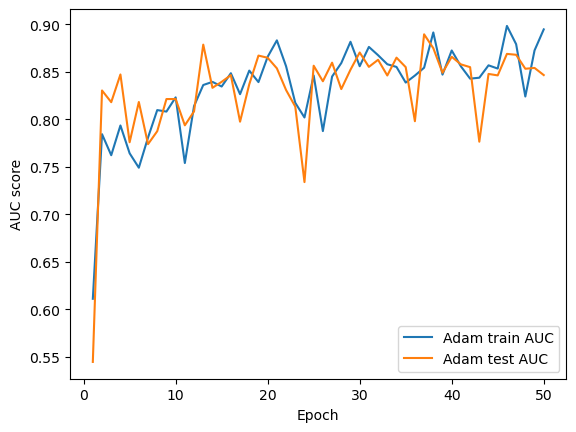

In [15]:
import copy
optimizers = {
    'Adam': Adam(model.parameters(), lr=lr, weight_decay=1e-4),
    # 'SGD': SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
}

best_models = {}
best_aucs = {}

for optimizer_name, optimizer in optimizers.items():
    print(f"Training with {optimizer_name} optimizer...")

    model.train()  # Reset the model to training mode

    best_auc = 0
    best_acc = 0
    best_epoch = 0

    train_auc_scores = []
    test_auc_scores = []
    epochs = []

    for epoch in range(NUM_EPOCHS):
        train_correct = 0
        train_total = 0
        train_loss = 0
        model.train()
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.float().to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

        # Evaluate after each epoch
        print(f"==> Evaluating after epoch {epoch + 1} ...")
        train_metrics = evaluate(train_loader)
        test_metrics = evaluate(test_loader)
        
        print(f"Train AUC: {train_metrics[0]}, Train ACC: {train_metrics[1]}")
        print(f"Test AUC: {test_metrics[0]}, Test ACC: {test_metrics[1]}")

        # Check if AUC score improved
        if test_metrics[0] > best_auc:
            best_auc = test_metrics[0]
            best_acc = test_metrics[1]
            best_epoch = epoch + 1
            print(f"==> Best test AUC and ACC score updated: {best_auc:.4f}, {best_acc:.4f}")
            best_models[optimizer_name] = {
                'state_dict': copy.deepcopy(model.state_dict()),
                'auc': best_auc,
                'acc': best_acc,
                'epoch': best_epoch
            }

        # Append AUC scores and epoch numbers
        train_auc_scores.append(train_metrics[0])
        test_auc_scores.append(test_metrics[0])
        epochs.append(epoch+1)

    best_aucs[optimizer_name] = best_auc

    # Plot the train and test AUC scores vs epoch for each optimizer
    plt.plot(epochs, train_auc_scores, label=f"{optimizer_name} train AUC")
    plt.plot(epochs, test_auc_scores, label=f"{optimizer_name} test AUC")

# Find the optimizer with the best AUC score
best_optimizer = max(best_aucs, key=best_aucs.get)
best_model_info = best_models[best_optimizer]

# Save the best model
torch.save(best_model_info['state_dict'], 'best_pretrained_model_adrenalmnist3d.pth')

print(f"Best model: {best_optimizer}, AUC: {best_model_info['auc']:.4f}, ACC: {best_model_info['acc']:.4f}, epoch: {best_model_info['epoch']}")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC score')
plt.show()

# LibAUC

In [16]:
# Get the current working directory
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

# List the files in the current directory
files = os.listdir(current_directory)
print("Files in the current directory:")
for file in files:
    print(file)

Current working directory: d:\Download\CSCE633\project
Files in the current directory:
AdrenalMNIST3D.ipynb
AdrenalMNIST3D_pretrained_batch128.png
AdrenalMNIST3D_pretrained_batch32_ep50.png
best_model_adrenalmnist3d.pth
best_model_breastmnist.pth
best_model_breastmnist_no_dropout.pth
best_model_chestmnist.pth
best_model_nodulemnist3d.pth
best_model_pneumoniamnist.pth
best_model_pneumoniamnist_no_dropout.pth
best_model_synapsemnist3d.pth
best_model_vesselmnist3d.pth
best_pretraind_model_breastmnist.pth
best_pretraind_model_pneumoniamnist.pth
best_pretrained_model_adrenalmnist3d.pth
best_pretrained_model_chestmnist.pth
best_pretrained_model_nodulemnist3d.pth
best_pretrained_model_pneumoniamnist.pth
best_pretrained_model_synapsemnist3d.pth
best_pretrained_model_vesselmnist3d.pth
BreastMNIST.ipynb
ChestMNIST.ipynb
CSE633-Spring23-Project-Description.pdf.pdf
data
get_started.ipynb
load_all_data.ipynb
NoduleMNIST3D.ipynb
PneumoniaMNIST.ipynb
resnet2p1d.py
SynapseMNIST3D.ipynb
VesselMNIST3D.i

## Resnet18-3D

In [17]:
model.load_state_dict(torch.load("best_pretrained_model_adrenalmnist3d.pth"))

<All keys matched successfully>

In [18]:
SEED = 123
BATCH_SIZE = 32
lr = 0.001 # using smaller learning rate is better
epoch_decay = 2e-3
weight_decay = 0.003
margin = 1.0

In [19]:
# define loss & optimizer
loss_fn = AUCMLoss()
optimizer = PESG(model, 
                 loss_fn=loss_fn, 
                 lr=lr, 
                 margin=margin, 
                 epoch_decay=epoch_decay, 
                 weight_decay=weight_decay)

100%|██████████| 38/38 [00:16<00:00,  2.29it/s]


==> Evaluating after epoch 1 ...
Train AUC: 0.852234548904216, Train ACC: 20.936026936026938
Test AUC: 0.8581508375883378, Test ACC: 19.583892617449663
==> Best test AUC and ACC score updated: 0.8582, 19.5839


100%|██████████| 38/38 [00:16<00:00,  2.30it/s]


==> Evaluating after epoch 2 ...
Train AUC: 0.8568515314776558, Train ACC: 20.91919191919192
Test AUC: 0.8518752960002958, Test ACC: 20.06040268456376


100%|██████████| 38/38 [00:16<00:00,  2.30it/s]


==> Evaluating after epoch 3 ...
Train AUC: 0.8454755291786779, Train ACC: 20.675084175084177
Test AUC: 0.8560524568024569, Test ACC: 19.19463087248322


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]


==> Evaluating after epoch 4 ...
Train AUC: 0.8407534543220893, Train ACC: 20.483164983164983
Test AUC: 0.8597153217153217, Test ACC: 19.308724832214764
==> Best test AUC and ACC score updated: 0.8597, 19.3087


100%|██████████| 38/38 [00:16<00:00,  2.30it/s]


==> Evaluating after epoch 5 ...
Train AUC: 0.8264071428969205, Train ACC: 20.944444444444443
Test AUC: 0.8507390988640988, Test ACC: 19.201342281879196


100%|██████████| 38/38 [00:16<00:00,  2.35it/s]


==> Evaluating after epoch 6 ...
Train AUC: 0.8572801811332548, Train ACC: 20.40909090909091
Test AUC: 0.8582022260147261, Test ACC: 18.926174496644297


100%|██████████| 38/38 [00:16<00:00,  2.30it/s]


==> Evaluating after epoch 7 ...
Train AUC: 0.844076548452732, Train ACC: 20.395622895622896
Test AUC: 0.8739676110926112, Test ACC: 18.758389261744966
==> Best test AUC and ACC score updated: 0.8740, 18.7584


100%|██████████| 38/38 [00:16<00:00,  2.31it/s]


==> Evaluating after epoch 8 ...
Train AUC: 0.8450344631883878, Train ACC: 19.74915824915825
Test AUC: 0.8737902028527028, Test ACC: 18.778523489932887


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]


==> Evaluating after epoch 9 ...
Train AUC: 0.8686428548830899, Train ACC: 19.614478114478114
Test AUC: 0.8633902671402671, Test ACC: 18.70469798657718


100%|██████████| 38/38 [00:16<00:00,  2.28it/s]


==> Evaluating after epoch 10 ...
Train AUC: 0.8576202225099983, Train ACC: 19.30808080808081
Test AUC: 0.8586360283235284, Test ACC: 18.758389261744966


100%|██████████| 38/38 [00:16<00:00,  2.31it/s]


==> Evaluating after epoch 11 ...
Train AUC: 0.8513923560449975, Train ACC: 18.555555555555557
Test AUC: 0.8839227300477301, Test ACC: 17.70469798657718
==> Best test AUC and ACC score updated: 0.8839, 17.7047


100%|██████████| 38/38 [00:16<00:00,  2.29it/s]


==> Evaluating after epoch 12 ...
Train AUC: 0.8669081571555831, Train ACC: 18.747474747474747
Test AUC: 0.8701144943019943, Test ACC: 18.19463087248322


100%|██████████| 38/38 [00:16<00:00,  2.28it/s]


==> Evaluating after epoch 13 ...
Train AUC: 0.8499084414058178, Train ACC: 18.338383838383837
Test AUC: 0.8800556804306805, Test ACC: 17.677852348993287


100%|██████████| 38/38 [00:16<00:00,  2.33it/s]


==> Evaluating after epoch 14 ...
Train AUC: 0.8689584056279984, Train ACC: 17.74915824915825
Test AUC: 0.8497560356310355, Test ACC: 17.42281879194631


100%|██████████| 38/38 [00:16<00:00,  2.30it/s]


==> Evaluating after epoch 15 ...
Train AUC: 0.8542908595054397, Train ACC: 18.535353535353536
Test AUC: 0.8939092735967737, Test ACC: 17.845637583892618
==> Best test AUC and ACC score updated: 0.8939, 17.8456


100%|██████████| 38/38 [00:16<00:00,  2.31it/s]


==> Evaluating after epoch 16 ...
Train AUC: 0.861712091997928, Train ACC: 17.762626262626263
Test AUC: 0.8809297022422022, Test ACC: 16.516778523489933


100%|██████████| 38/38 [00:16<00:00,  2.29it/s]


==> Evaluating after epoch 17 ...
Train AUC: 0.8588684113412373, Train ACC: 17.077441077441076
Test AUC: 0.8746295463795463, Test ACC: 15.449664429530202


100%|██████████| 38/38 [00:16<00:00,  2.28it/s]


==> Evaluating after epoch 18 ...
Train AUC: 0.8637569722054207, Train ACC: 17.245791245791246
Test AUC: 0.8780298798423798, Test ACC: 16.59731543624161


100%|██████████| 38/38 [00:16<00:00,  2.29it/s]


==> Evaluating after epoch 19 ...
Train AUC: 0.8581236671516204, Train ACC: 16.656565656565657
Test AUC: 0.8720975806600807, Test ACC: 16.28187919463087


100%|██████████| 38/38 [00:17<00:00,  2.22it/s]


==> Evaluating after epoch 20 ...
Train AUC: 0.8546655534155536, Train ACC: 17.468013468013467
Test AUC: 0.8670225376475376, Test ACC: 16.87248322147651


100%|██████████| 38/38 [00:16<00:00,  2.31it/s]


==> Evaluating after epoch 21 ...
Train AUC: 0.8539264326579521, Train ACC: 17.925925925925927
Test AUC: 0.8661715853590854, Test ACC: 16.375838926174495


100%|██████████| 38/38 [00:16<00:00,  2.30it/s]


==> Evaluating after epoch 22 ...
Train AUC: 0.8611977175639096, Train ACC: 17.003367003367003
Test AUC: 0.8712066058941058, Test ACC: 16.140939597315437


100%|██████████| 38/38 [00:16<00:00,  2.30it/s]


==> Evaluating after epoch 23 ...
Train AUC: 0.838127279649019, Train ACC: 17.503367003367003
Test AUC: 0.8631323953823953, Test ACC: 17.154362416107382


100%|██████████| 38/38 [00:16<00:00,  2.29it/s]


==> Evaluating after epoch 24 ...
Train AUC: 0.849321997499915, Train ACC: 17.33164983164983
Test AUC: 0.8501594817219817, Test ACC: 16.624161073825505


100%|██████████| 38/38 [00:16<00:00,  2.25it/s]


==> Evaluating after epoch 25 ...
Train AUC: 0.8547962255305867, Train ACC: 17.053872053872055
Test AUC: 0.8555251392126392, Test ACC: 16.308724832214764


100%|██████████| 38/38 [00:16<00:00,  2.25it/s]


==> Evaluating after epoch 26 ...
Train AUC: 0.8590234944995064, Train ACC: 17.537037037037038
Test AUC: 0.8902604432604434, Test ACC: 17.16778523489933


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]


==> Evaluating after epoch 27 ...
Train AUC: 0.8608160719058887, Train ACC: 17.2003367003367
Test AUC: 0.886388488825989, Test ACC: 17.16778523489933


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]


==> Evaluating after epoch 28 ...
Train AUC: 0.8554621793021342, Train ACC: 17.718855218855218
Test AUC: 0.8759269133644132, Test ACC: 17.06711409395973


100%|██████████| 38/38 [00:16<00:00,  2.26it/s]


==> Evaluating after epoch 29 ...
Train AUC: 0.8403242609904361, Train ACC: 17.031986531986533
Test AUC: 0.8792016409516409, Test ACC: 16.053691275167786


100%|██████████| 38/38 [00:16<00:00,  2.29it/s]


==> Evaluating after epoch 30 ...
Train AUC: 0.8630161371588437, Train ACC: 16.937710437710436
Test AUC: 0.8529961889961891, Test ACC: 16.536912751677853


100%|██████████| 38/38 [00:16<00:00,  2.25it/s]


==> Evaluating after epoch 31 ...
Train AUC: 0.8661276487240446, Train ACC: 17.042087542087543
Test AUC: 0.8729576118326119, Test ACC: 15.89261744966443


100%|██████████| 38/38 [00:17<00:00,  2.23it/s]


==> Evaluating after epoch 32 ...
Train AUC: 0.8596038974028104, Train ACC: 17.348484848484848
Test AUC: 0.8813810541310542, Test ACC: 17.751677852348994


100%|██████████| 38/38 [00:17<00:00,  2.22it/s]


==> Evaluating after epoch 33 ...
Train AUC: 0.8553893133194108, Train ACC: 17.47979797979798
Test AUC: 0.8686191678691678, Test ACC: 16.845637583892618


100%|██████████| 38/38 [00:17<00:00,  2.23it/s]


==> Evaluating after epoch 34 ...
Train AUC: 0.8703299274821901, Train ACC: 16.420875420875422
Test AUC: 0.8817661204536205, Test ACC: 15.657718120805368


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]


==> Evaluating after epoch 35 ...
Train AUC: 0.8535934331120948, Train ACC: 17.40740740740741
Test AUC: 0.8773337333962334, Test ACC: 15.912751677852349


100%|██████████| 38/38 [00:16<00:00,  2.25it/s]


==> Evaluating after epoch 36 ...
Train AUC: 0.8690674143657603, Train ACC: 16.217171717171716
Test AUC: 0.8597737147112147, Test ACC: 15.691275167785236


100%|██████████| 38/38 [00:16<00:00,  2.25it/s]


==> Evaluating after epoch 37 ...
Train AUC: 0.8597901301769635, Train ACC: 17.227272727272727
Test AUC: 0.8568615412365412, Test ACC: 17.026845637583893


100%|██████████| 38/38 [00:16<00:00,  2.29it/s]


==> Evaluating after epoch 38 ...
Train AUC: 0.8440516497010125, Train ACC: 17.106060606060606
Test AUC: 0.8847242040367039, Test ACC: 15.74496644295302


100%|██████████| 38/38 [00:18<00:00,  2.09it/s]


==> Evaluating after epoch 39 ...
Train AUC: 0.8744876040007423, Train ACC: 16.043771043771045
Test AUC: 0.8808194629444628, Test ACC: 14.845637583892618


100%|██████████| 38/38 [00:16<00:00,  2.26it/s]


==> Evaluating after epoch 40 ...
Train AUC: 0.8747898473935617, Train ACC: 16.013468013468014
Test AUC: 0.8902580336330335, Test ACC: 15.181208053691275


100%|██████████| 38/38 [00:16<00:00,  2.24it/s]


==> Evaluating after epoch 41 ...
Train AUC: 0.8321055565880988, Train ACC: 16.062289562289564
Test AUC: 0.8852764272764272, Test ACC: 16.241610738255034


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]


==> Evaluating after epoch 42 ...
Train AUC: 0.8640245167662709, Train ACC: 16.282828282828284
Test AUC: 0.8614454087579088, Test ACC: 15.577181208053691


100%|██████████| 38/38 [00:17<00:00,  2.13it/s]


==> Evaluating after epoch 43 ...
Train AUC: 0.8675593696779981, Train ACC: 15.575757575757576
Test AUC: 0.8624932636807637, Test ACC: 15.181208053691275


100%|██████████| 38/38 [00:16<00:00,  2.26it/s]


==> Evaluating after epoch 44 ...
Train AUC: 0.8667173901084088, Train ACC: 16.23905723905724
Test AUC: 0.8598002229252231, Test ACC: 16.469798657718123


100%|██████████| 38/38 [00:16<00:00,  2.30it/s]


==> Evaluating after epoch 45 ...
Train AUC: 0.880536496607951, Train ACC: 16.67845117845118
Test AUC: 0.8854347273097274, Test ACC: 16.395973154362416


100%|██████████| 38/38 [00:17<00:00,  2.22it/s]


==> Evaluating after epoch 46 ...
Train AUC: 0.8759846552030479, Train ACC: 15.582491582491583
Test AUC: 0.8682396584896583, Test ACC: 15.838926174496644


100%|██████████| 38/38 [00:16<00:00,  2.24it/s]


==> Evaluating after epoch 47 ...
Train AUC: 0.8651366914398954, Train ACC: 16.14983164983165
Test AUC: 0.8852956580456581, Test ACC: 15.610738255033556


100%|██████████| 38/38 [00:16<00:00,  2.29it/s]


==> Evaluating after epoch 48 ...
Train AUC: 0.8557130067920883, Train ACC: 16.286195286195287
Test AUC: 0.8713336755836757, Test ACC: 15.38255033557047


100%|██████████| 38/38 [00:16<00:00,  2.27it/s]


==> Evaluating after epoch 49 ...
Train AUC: 0.8567344434516054, Train ACC: 16.023569023569024
Test AUC: 0.8983847194472194, Test ACC: 15.818791946308725
==> Best test AUC and ACC score updated: 0.8984, 15.8188


100%|██████████| 38/38 [00:16<00:00,  2.30it/s]


==> Evaluating after epoch 50 ...
Train AUC: 0.8465361304078459, Train ACC: 15.84006734006734
Test AUC: 0.8648591246716247, Test ACC: 15.315436241610739
Best test AUC: 0.8984 and ACC: 15.8188 achieved at epoch 49


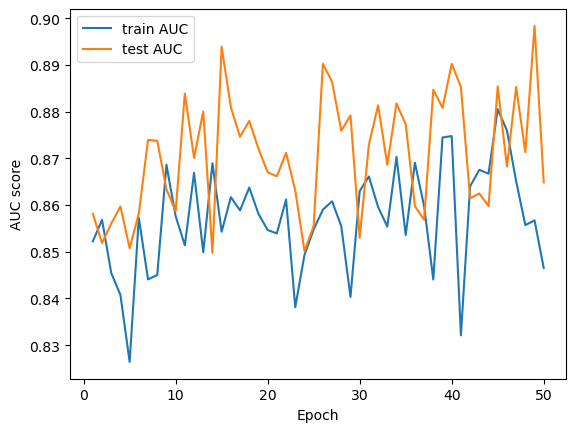

In [20]:
# training and testing
best_auc = 0
best_acc = 0
best_epoch = 0
patience = NUM_EPOCHS
stop_counter = 0

train_auc_scores = []
test_auc_scores = []
epochs = []

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    train_loss = 0
    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.float().to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        targets = targets.squeeze().long()
        loss = loss_fn(outputs, targets)
        
        loss.backward()
        optimizer.step()

    # Evaluate after each epoch
    print(f"==> Evaluating after epoch {epoch + 1} ...")
    train_metrics = evaluate(train_loader)
    test_metrics = evaluate(test_loader)

    print(f"Train AUC: {train_metrics[0]}, Train ACC: {train_metrics[1]}")
    print(f"Test AUC: {test_metrics[0]}, Test ACC: {test_metrics[1]}")

    # Check if AUC score improved
    if test_metrics[0] > best_auc:
        best_auc = test_metrics[0]
        best_acc = test_metrics[1]
        best_epoch = epoch + 1
        print(f"==> Best test AUC and ACC score updated: {best_auc:.4f}, {best_acc:.4f}")
        # Save the model state
        torch.save(model.state_dict(), 'best_model_adrenalmnist3d.pth')
    #     stop_counter = 0
    # else:
    #     stop_counter += 1

    # Append AUC scores and epoch numbers
    train_auc_scores.append(train_metrics[0])
    test_auc_scores.append(test_metrics[0])
    epochs.append(epoch+1)

    # Check for early stopping
    # if stop_counter >= patience:
    #     print("Early stopping triggered")
    #     break

print(f"Best test AUC: {best_auc:.4f} and ACC: {best_acc:.4f} achieved at epoch {best_epoch}")

# Plot the train and test AUC scores vs epoch
plt.plot(epochs, train_auc_scores, label='train AUC')
plt.plot(epochs, test_auc_scores, label='test AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC score')
plt.show()